Gurleen Kaur (gkaur22) and Devika Tiwari <br>
CS 418 Spring 2022 <br>
Final Project

In [10]:
# import libraries
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import requests
from fbprophet import Prophet

## Data Collection

In [102]:
# create empty dataframes to store data into 
col_titles = ["date", "min", "avg", "max"]
winter_df = pd.DataFrame(columns=col_titles)
summer_df = pd.DataFrame(columns=col_titles)

# takes in a string date, makes request, captures temperature data,
# and adds it to the end of the dataframe
def getData(df, date):
    """ Takes in a dataframe and the date and inserts the min, avg, and
        max temperatures of that date to the dataframe. """

    url = requests.get("https://www.almanac.com/weather/history/IL/Chicago/" + date)
    content = url.text
    html = pd.read_html(content, header=0)[0]

    html["date"] = date
    data = [html.iloc[0][2], html.iloc[0][1], html.iloc[1][1], html.iloc[2][1]]
    df.loc[len(df)] = data

# generate dates to capture temperature data of:
# Summer range: 1946-06-21 to 2020-09-22
# Winter range: 1945-12-21 to 2020-03-20
years = range(1946,2021)
summer_start = '06-21'
summer_end = '09-22'
winter_start = '12-21'
winter_end = '03-20'
summer_dates = []
winter_dates = []
for y in years:
    ss = str(y) + '-' + summer_start
    se = str(y) + '-' + summer_end
    ws = str(y-1) + '-' + winter_start
    we = str(y) + '-' + winter_end
    summer = pd.date_range(ss, se, freq = 'D')
    for s in summer:
        summer_dates.append(str(s.date()))
    winter = pd.date_range(ws, we, freq = 'D')
    for w in winter:
        winter_dates.append(str(w.date()))

In [98]:
# make requests in batches of 1000 to avoid TimeoutError
batch = range(0, len(winter_dates), 1000)
for dates in [winter_dates[i : i + 1000] for i in batch]:
    for date in dates:
        getData(winter_df, date)

# store dataframes in CSV file to avoid recollecting data.
winter_df.to_csv("winter_data.csv")

In [106]:
# make requests in batches of 500 to avoid TimeoutError
batch = range(0, len(summer_dates), 500)
for dates in [summer_dates[i : i + 500] for i in batch]:
    for date in dates:
        getData(summer_df, date)     

# store dataframes in CSV file to avoid recollecting data.  
summer_df.to_csv("summer_data.csv")


In [11]:
# Read data from CSV files to avoid collecting data from source again
winter_df = pd.read_csv('winter_data.csv', index_col=0)
summer_df = pd.read_csv('summer_data.csv', index_col=0)

In [12]:
# Clean data
# Remove ºF from temperature data
def removeUnit(val):
    ''' Removes the unit from the value. Returns value.'''
    new = str(val)
    new = new[ : new.find(' ')]
    return new

winter_df['min'] = winter_df['min'].apply(removeUnit)
winter_df['avg'] = winter_df['avg'].apply(removeUnit)
winter_df['max'] = winter_df['max'].apply(removeUnit)
summer_df['min'] = summer_df['min'].apply(removeUnit)
summer_df['avg'] = summer_df['avg'].apply(removeUnit)
summer_df['max'] = summer_df['max'].apply(removeUnit)

# Create year column by extracting year from date column
winter_df['date'] = pd.to_datetime(winter_df['date'])
summer_df['date'] = pd.to_datetime(summer_df['date'])
winter_df['year'] = pd.DatetimeIndex(winter_df['date']).year
summer_df['year'] = pd.DatetimeIndex(summer_df['date']).year

# Convert temperature data to numeric values
winter_df['min'] = pd.to_numeric(winter_df['min'])
winter_df['avg'] = pd.to_numeric(winter_df['avg'])
winter_df['max'] = pd.to_numeric(winter_df['max'])
summer_df['min'] = pd.to_numeric(summer_df['min'])
summer_df['avg'] = pd.to_numeric(summer_df['avg'])
summer_df['max'] = pd.to_numeric(summer_df['max'])



In [13]:
# Group data by season and temperature type and store into CSV files 
winter_min_summary_df = winter_df.groupby(['year'])['min'].describe()
winter_min_summary_df.to_csv('winter_min_summary')
winter_avg_summary_df = winter_df.groupby(['year'])['avg'].describe()
winter_avg_summary_df.to_csv('winter_avg_summary')
winter_max_summary_df = winter_df.groupby(['year'])['max'].describe()
winter_max_summary_df.to_csv('winter_max_summary')
summer_min_summary_df = summer_df.groupby(['year'])['min'].describe()
summer_min_summary_df.to_csv('summer_min_summary')
summer_avg_summary_df = summer_df.groupby(['year'])['avg'].describe()
summer_avg_summary_df.to_csv('summer_avg_summary')
summer_max_summary_df = summer_df.groupby(['year'])['max'].describe()
summer_max_summary_df.to_csv('summer_max_summary')

## EDA

<AxesSubplot:title={'center':'Average Winter Min Temperature'}, xlabel='year'>

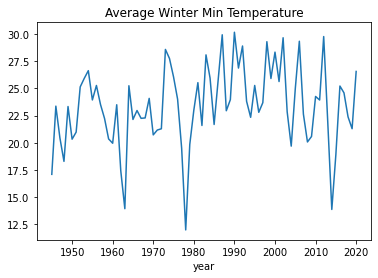

In [15]:
winter_df.groupby(['year'])['min'].mean().plot(title = 'Average Winter Min Temperature')

<AxesSubplot:title={'center':'Average Winter Mean Temperature'}, xlabel='year'>

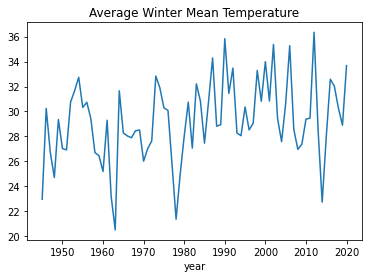

In [16]:
winter_df.groupby(['year'])['avg'].mean().plot(title = 'Average Winter Mean Temperature')

<AxesSubplot:title={'center':'Average Winter Max Temperature'}, xlabel='year'>

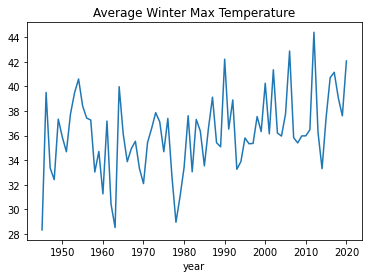

In [17]:
winter_df.groupby(['year'])['max'].mean().plot(title = 'Average Winter Max Temperature')

<AxesSubplot:title={'center':'Average Summer Min Temperature'}, xlabel='year'>

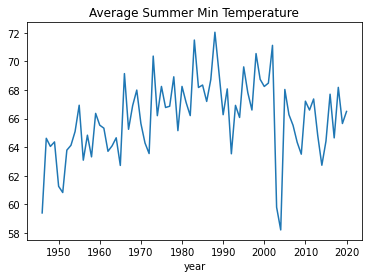

In [18]:
summer_df.groupby(['year'])['min'].mean().plot(title = 'Average Summer Min Temperature')

<AxesSubplot:title={'center':'Average Summer Mean Temperature'}, xlabel='year'>

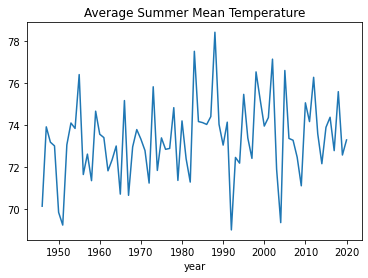

In [19]:
summer_df.groupby(['year'])['avg'].mean().plot(title = 'Average Summer Mean Temperature')

<AxesSubplot:title={'center':'Average Summer Max Temperature'}, xlabel='year'>

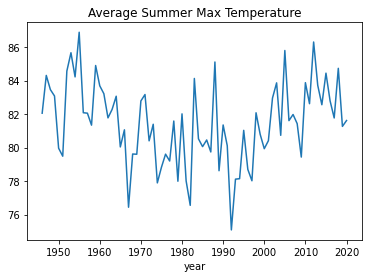

In [20]:
summer_df.groupby(['year'])['max'].mean().plot(title = 'Average Summer Max Temperature')

## Univariate Time Series Modeling

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
import pmdarima as pm
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [22]:
# Taken from https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

## Summer Average ARIMA and SARIMA

In [24]:
# Test for stationary data:
# - want to see large negative ADF value and p-val < 0.05
train_summer_avg_df = summer_df.iloc[:5639]['avg']
ad_test(train_summer_avg_df)

1. ADF :  -14.168250717255814
2. P-Value :  2.0244416606533113e-26
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression: 5626
5. Critical Values :
	 1% :  -3.431512866362768
	 5% :  -2.8620538737721883
	 10% :  -2.567043533467653


p-value < 0.05; therefore, data is stationary. Proceed with using ARIMA

In [25]:
# Finds the ideal p,d,q parameters
# Set d = 0 because data is stationary
summer_avg_stepwise_fit = auto_arima(train_summer_avg_df, trace=True, suppress_warnings=True, d=0)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=32474.475, Time=4.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=37167.588, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=32758.261, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=33721.504, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=64480.090, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=32504.522, Time=2.53 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=32513.255, Time=2.77 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=32471.540, Time=2.16 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=32453.085, Time=4.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=32475.550, Time=0.94 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=32467.649, Time=2.68 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=32574.628, Time=0.27 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=32465.755, Time=0.74 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=32451.785, Time=4.37 sec
 ARIMA(5,0,2)(0,0,0

## best parameters: (1, 0, 4)

Text(0.5, 1.0, 'ARIMA on Summer Avg Training Data')

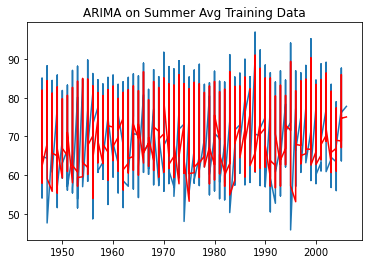

In [26]:
# running model with parameters from above
summer_avg_model = ARIMA(train_summer_avg_df, order=(1,0,4))
summer_avg_results_ARIMA = summer_avg_model.fit()
plt.plot(summer_df.iloc[:5639]['year'],train_summer_avg_df)
plt.plot((summer_df.iloc[:5639]['year']), summer_avg_results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA on Summer Avg Training Data')

In [27]:
print(summer_avg_results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                    avg   No. Observations:                 5639
Model:                 ARIMA(1, 0, 4)   Log Likelihood              -16209.296
Date:                Thu, 05 May 2022   AIC                          32432.593
Time:                        18:09:10   BIC                          32479.055
Sample:                             0   HQIC                         32448.778
                               - 5639                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         73.2782      0.287    255.149      0.000      72.715      73.841
ar.L1          0.9110      0.015     62.190      0.000       0.882       0.940
ma.L1         -0.0314      0.019     -1.629      0.1

In [28]:
# Calculate training MSE
print(mean_squared_error(train_summer_avg_df, summer_avg_results_ARIMA.fittedvalues))

18.396447552016937


<AxesSubplot:>

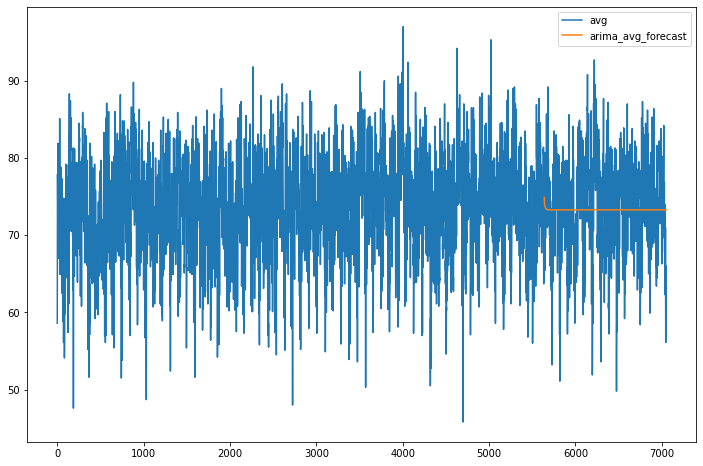

In [35]:
# Use arima to forecast temperatures 2006-2020
summer_avg_predictions = summer_avg_results_ARIMA.predict(start=5640, end=7049, dynamic=True)
summer_df['arima_avg_forecast'] = summer_avg_predictions
summer_df[['avg','arima_avg_forecast']].plot(figsize=(12,8))

In [38]:
# test if residuals are correlated using Ljung-Box test
acorr_ljungbox(summer_avg_results_ARIMA.resid)
# Residuals are not correlated --> can do time series forecasting

,lb_stat,lb_pvalue
1,0.001087,0.973700
2,0.010093,0.994966
3,0.055469,0.996583
4,0.065445,0.999476
5,1.037242,0.959506
6,1.090134,0.981964
7,1.108443,0.992885
8,1.112875,0.997430
9,1.113874,0.999127
10,1.380900,0.999261


In [32]:
# Summer average test MSE
print(mean_squared_error(summer_df.iloc[5638:]['avg'], summer_avg_predictions))

38.28713009076166


## SARIMA: Seasonal ARIMA
m = number of periods in one cycle = 3 (3 months of summer)

In [40]:
summer_avg_m3 = pm.auto_arima(train_summer_avg_df, error_action='ignore', seasonal=True, m=3)
summer_avg_m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 5639
Model:             SARIMAX(0, 1, 2)x(2, 0, [1], 3)   Log Likelihood              -16346.220
Date:                             Thu, 05 May 2022   AIC                          32704.440
Time:                                     18:25:42   BIC                          32744.264
Sample:                                          0   HQIC                         32718.313
                                            - 5639                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1083      0.012     -9.103      0.000      -0.132      -0.085
ma.L2         -0.4048      0.011    -35.730      0.000      -0.427      -0.383
ar.S.L3        0.4925      0.075      6.534      0.000       0.345       0.640
ar.S.L6        0.0400      0.022      1.816      0.069      -0.003       0.083
ma.S.L3       -0.6759      0.074     -9.177      0.000      -0.820      -0.532
sigma2        19.3093      0.292     66.168      0.000      18.737      19.881
===================================================================================
Ljung-Box (L1) (Q):                   3.76   Jarque-Bera (JB):               552.09
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.06
Prob(H) (two-sided):                  0.53   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

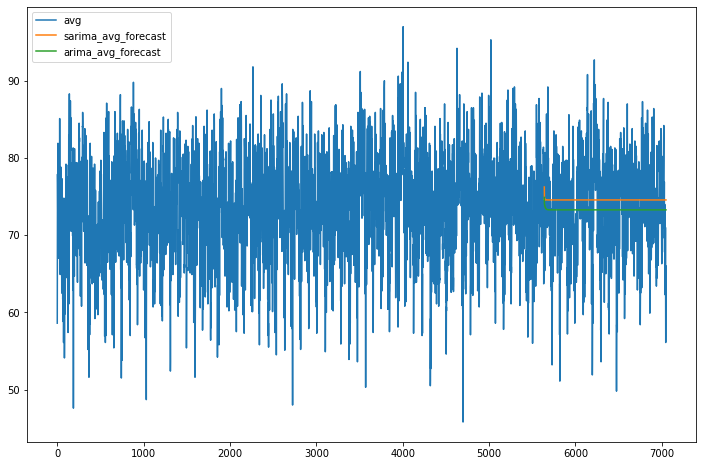

In [42]:
summer_avg_sarima_predict = summer_avg_m3.predict(n_periods = 1410)
summer_avg_sarima_predict_series = pd.Series(summer_avg_sarima_predict, index = range(5640, 7050))
summer_df['sarima_avg_forecast'] = summer_avg_sarima_predict_series
summer_df[['avg','sarima_avg_forecast', 'arima_avg_forecast']].plot(figsize=(12,8))

In [43]:
# Summer avg SARIMA test predictions MSE
print(mean_squared_error(summer_df.iloc[5639:]['avg'], summer_df.iloc[5639:]['sarima_avg_forecast']))

39.12910286906579


## Summer Min ARIMA and SARIMA

In [47]:
train_summer_min_df = summer_df.iloc[:5639]['min']
ad_test(train_summer_min_df)

1. ADF :  -12.804970240107053
2. P-Value :  6.630725802947928e-24
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression: 5627
5. Critical Values :
	 1% :  -3.431512659610059
	 5% :  -2.8620537824254733
	 10% :  -2.5670434848409958


In [48]:
summer_min_stepwise_fit = auto_arima(train_summer_min_df, trace=True, suppress_warnings=True, d=0)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=33309.359, Time=4.64 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=37716.105, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=33428.496, Time=0.33 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=34810.581, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=63340.227, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=33363.168, Time=2.65 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=33431.654, Time=2.25 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=33346.502, Time=5.05 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=33294.131, Time=4.50 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=33287.229, Time=3.97 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=33733.948, Time=1.01 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=33280.276, Time=5.94 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=33628.865, Time=1.51 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=33290.191, Time=5.07 sec
 ARIMA(1,0,5)(0,0,0

Text(0.5, 1.0, 'ARIMA on Summer Min Training Data')

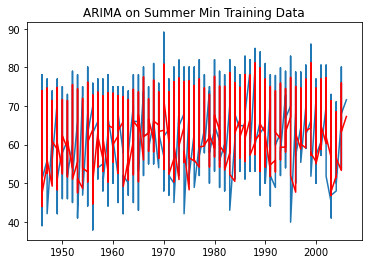

In [49]:
summer_min_model = ARIMA(train_summer_min_df, order=(1,0,4))
summer_min_results_ARIMA = summer_min_model.fit()
plt.plot(summer_df.iloc[:5639]['year'],train_summer_min_df)
plt.plot((summer_df.iloc[:5639]['year']), summer_min_results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA on Summer Min Training Data')

In [50]:
print(summer_min_results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                    min   No. Observations:                 5639
Model:                 ARIMA(1, 0, 4)   Log Likelihood              -16633.138
Date:                Thu, 05 May 2022   AIC                          33280.277
Time:                        18:33:27   BIC                          33326.739
Sample:                             0   HQIC                         33296.462
                               - 5639                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.1363      0.401    165.014      0.000      65.351      66.922
ar.L1          0.9423      0.009    108.945      0.000       0.925       0.959
ma.L1         -0.2183      0.014    -15.270      0.0

In [51]:
print("Summer Min Train MSE: ",mean_squared_error(train_summer_min_df, summer_min_results_ARIMA.fittedvalues))

Summer Min Train MSE:  21.380597903136277


<AxesSubplot:title={'center':'Summer Min ARIMA Forecast'}>

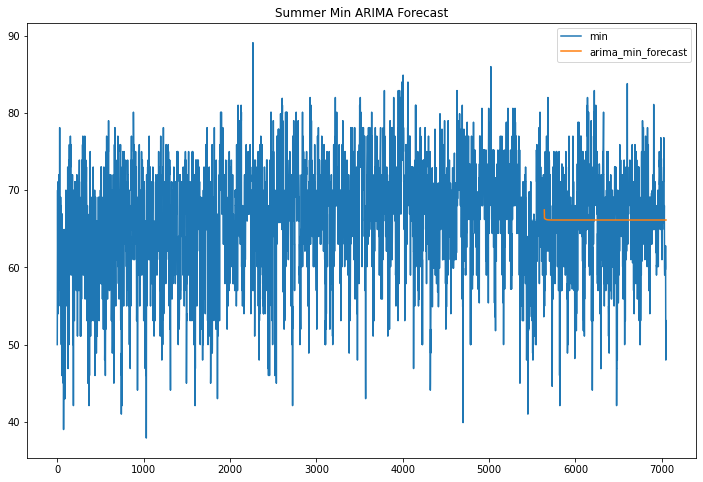

In [53]:
summer_min_predictions = summer_min_results_ARIMA.predict(start=5640, end=7049, dynamic=True)
summer_df['arima_min_forecast'] = summer_min_predictions
summer_df[['min','arima_min_forecast']].plot(figsize=(12,8), title = 'Summer Min ARIMA Forecast')

In [55]:
acorr_ljungbox(summer_min_results_ARIMA.resid)

,lb_stat,lb_pvalue
1,0.000001,0.999122
2,0.004760,0.997623
3,0.074402,0.994721
4,0.150864,0.997294
5,0.361074,0.996334
6,3.554732,0.736674
7,3.738174,0.809392
8,5.128704,0.743736
9,5.943497,0.745560
10,8.973044,0.534664


In [56]:
print("Summer Min Test ARIMA MSE: ", mean_squared_error(summer_df.iloc[5638:]['min'], summer_min_predictions))

Summer Min Test ARIMA MSE:  40.1394026219123


## Summer Min SARIMA

In [57]:
summer_min_m3 = pm.auto_arima(train_summer_min_df, error_action='ignore', seasonal=True, m=3)
summer_min_m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 5639
Model:             SARIMAX(2, 1, 2)x(0, 0, 2, 3)   Log Likelihood              -16668.454
Date:                           Thu, 05 May 2022   AIC                          33350.909
Time:                                   18:36:43   BIC                          33397.370
Sample:                                        0   HQIC                         33367.094
                                          - 5639                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0538      0.079     -0.683      0.495      -0.208       0.101
ar.L2          0.5114      0.060      8.485      0.000       0.393       0.630
ma.L1         -0.1977      0.076     -2.615      0.009      -0.346      -0.049
ma.L2         -0.7804      0.075    -10.414      0.000      -0.927      -0.634
ma.S.L3       -0.0532      0.014     -3.699      0.000      -0.081      -0.025
ma.S.L6        0.0336      0.014      2.447      0.014       0.007       0.060
sigma2        21.6429      0.339     63.781      0.000      20.978      22.308
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):               351.00
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:title={'center':'Summer Min SARIMA vs. ARIMA'}>

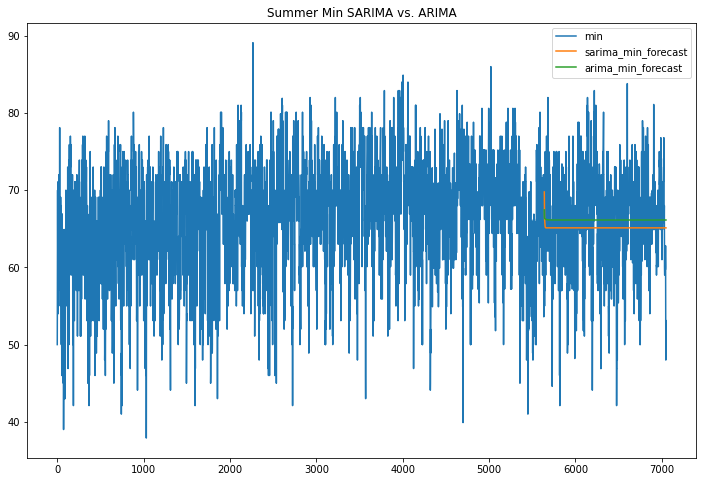

In [58]:
summer_min_sarima_predict = summer_min_m3.predict(n_periods = 1410)
summer_min_sarima_predict_series = pd.Series(summer_min_sarima_predict, index = range(5640, 7050))
summer_df['sarima_min_forecast'] = summer_min_sarima_predict_series
summer_df[['min','sarima_min_forecast', 'arima_min_forecast']].plot(figsize=(12,8), title = 'Summer Min SARIMA vs. ARIMA')

In [59]:
print("Summer Min Test SARIMA MSE", mean_squared_error(summer_df.iloc[5639:]['min'], summer_df.iloc[5639:]['sarima_min_forecast']))

Summer Min Test SARIMA MSE 40.3358586533231


## Summer Max ARIMA and SARIMA

In [60]:
train_summer_max_df = summer_df.iloc[:5639]['max']
ad_test(train_summer_max_df)

1. ADF :  -14.62991478044028
2. P-Value :  3.766400761761825e-27
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression: 5626
5. Critical Values :
	 1% :  -3.431512866362768
	 5% :  -2.8620538737721883
	 10% :  -2.567043533467653


In [61]:
summer_max_stepwise_fit = auto_arima(train_summer_max_df, trace=True, suppress_warnings=True, d=0)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=35851.387, Time=1.71 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=39031.040, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=35931.052, Time=0.38 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=36543.025, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=65638.914, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=35846.619, Time=3.31 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=36090.260, Time=0.74 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=35879.014, Time=1.19 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=35817.064, Time=3.99 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=35965.259, Time=1.12 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=35836.613, Time=2.51 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=35814.256, Time=4.92 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=35925.512, Time=1.61 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=35816.628, Time=5.00 sec
 ARIMA(1,0,5)(0,0,0

Text(0.5, 1.0, 'ARIMA on Summer Max Training Data')

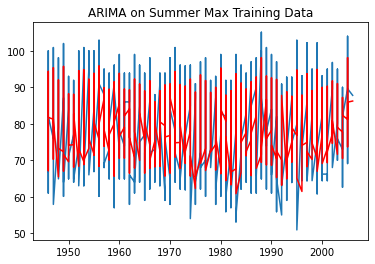

In [62]:
summer_max_model = ARIMA(train_summer_max_df, order=(1,0,4))
summer_max_results_ARIMA = summer_max_model.fit()
plt.plot(summer_df.iloc[:5639]['year'],train_summer_max_df)
plt.plot((summer_df.iloc[:5639]['year']), summer_max_results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA on Summer Max Training Data')

In [63]:
print(summer_max_results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                    max   No. Observations:                 5639
Model:                 ARIMA(1, 0, 4)   Log Likelihood              -17894.648
Date:                Thu, 05 May 2022   AIC                          35803.297
Time:                        18:39:23   BIC                          35849.759
Sample:                             0   HQIC                         35819.482
                               - 5639                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         81.1661      0.321    252.787      0.000      80.537      81.795
ar.L1          0.9284      0.014     65.865      0.000       0.901       0.956
ma.L1         -0.2260      0.019    -11.724      0.0

In [64]:
print("Summer Max Train MSE: ",mean_squared_error(train_summer_max_df, summer_max_results_ARIMA.fittedvalues))

Summer Max Train MSE:  33.423144769057636


,lb_stat,lb_pvalue
1,0.000280,0.986641
2,0.021008,0.989551
3,0.111564,0.990414
4,0.311891,0.989034
5,0.537361,0.990691
6,1.256115,0.974022
7,2.086357,0.954906
8,3.011692,0.933622
9,3.573394,0.937186
10,3.714822,0.959296


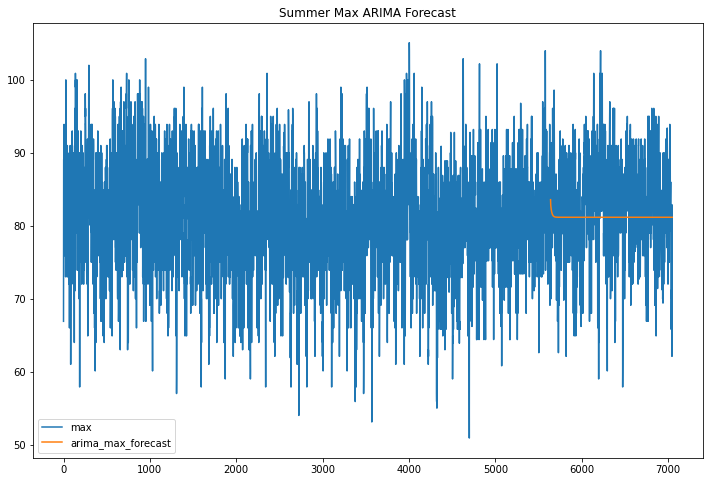

In [65]:
summer_max_predictions = summer_max_results_ARIMA.predict(start=5640, end=7049, dynamic=True)
summer_df['arima_max_forecast'] = summer_max_predictions
summer_df[['max','arima_max_forecast']].plot(figsize=(12,8), title = 'Summer Max ARIMA Forecast')
acorr_ljungbox(summer_max_results_ARIMA.resid)

In [66]:
print("Summer Max Test ARIMA MSE: ", mean_squared_error(summer_df.iloc[5638:]['max'], summer_max_predictions))

Summer Max Test ARIMA MSE:  51.373028923971084


In [67]:
summer_max_m3 = pm.auto_arima(train_summer_max_df, error_action='ignore', seasonal=True, m=3)
summer_max_m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 5639
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 3)   Log Likelihood              -18010.114
Date:                             Thu, 05 May 2022   AIC                          36030.228
Time:                                     18:42:52   BIC                          36063.415
Sample:                                          0   HQIC                         36041.789
                                            - 5639                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3042      0.013    -24.266      0.000      -0.329      -0.280
ma.L2         -0.4099      0.011    -37.274      0.000      -0.431      -0.388
ar.S.L3        0.6668      0.052     12.776      0.000       0.565       0.769
ma.S.L3       -0.7626      0.044    -17.217      0.000      -0.849      -0.676
sigma2        34.8402      0.564     61.828      0.000      33.736      35.945
===================================================================================
Ljung-Box (L1) (Q):                   7.36   Jarque-Bera (JB):               236.18
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.09
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:title={'center':'Summer Max SARIMA vs. ARIMA'}>

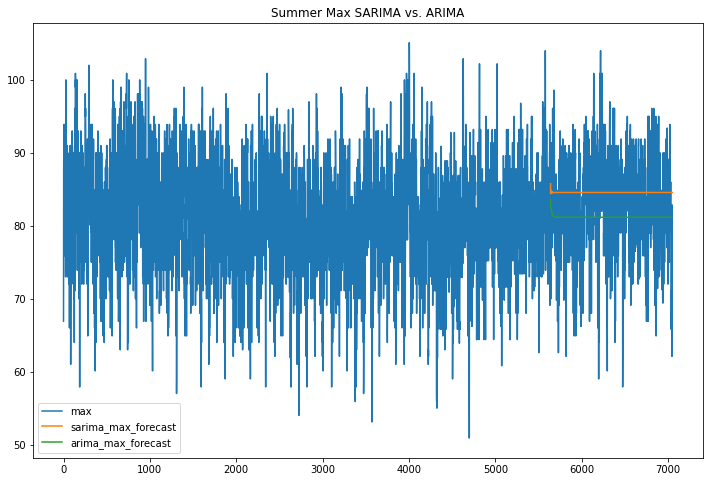

In [68]:
summer_max_sarima_predict = summer_max_m3.predict(n_periods = 1410)
summer_max_sarima_predict_series = pd.Series(summer_max_sarima_predict, index = range(5640, 7050))
summer_df['sarima_max_forecast'] = summer_max_sarima_predict_series
summer_df[['max','sarima_max_forecast', 'arima_max_forecast']].plot(figsize=(12,8), title = 'Summer Max SARIMA vs. ARIMA')

In [69]:
print("Summer Max Test SARIMA MSE", mean_squared_error(summer_df.iloc[5639:]['max'], summer_df.iloc[5639:]['sarima_max_forecast']))

Summer Max Test SARIMA MSE 52.751944382555294


## Winter Average ARIMA and SARIMA

In [71]:
# 6763 rows
# 80% = 5411 (starting = 2005)
train_winter_avg_df = winter_df.iloc[:5411]['avg']
ad_test(train_winter_avg_df)

1. ADF :  -14.571140925525514
2. P-Value :  4.626430740324843e-27
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression: 5399
5. Critical Values :
	 1% :  -3.431561782148421
	 5% :  -2.8620754853848718
	 10% :  -2.56705503802214


In [72]:
winter_avg_stepwise_fit = auto_arima(train_winter_avg_df, trace=True, suppress_warnings=True, d=0)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=36537.567, Time=2.99 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=41426.375, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=36772.124, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=37978.717, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=52579.109, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=36561.644, Time=1.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=36592.280, Time=1.70 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=36539.561, Time=4.55 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=36539.620, Time=4.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=36617.815, Time=0.79 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=36540.202, Time=1.59 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=36549.458, Time=2.84 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=36539.959, Time=4.60 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.50 sec

Best model:  ARIMA(2,0,2

Text(0.5, 1.0, 'ARIMA on Winter Avg Training Data')

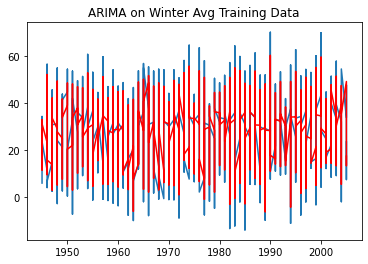

In [73]:
winter_avg_model = ARIMA(train_winter_avg_df, order=(2,0,2))
winter_avg_results_ARIMA = winter_avg_model.fit()
plt.plot(winter_df.iloc[:5411]['year'],train_winter_avg_df)
plt.plot((winter_df.iloc[:5411]['year']), winter_avg_results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA on Winter Avg Training Data')

In [74]:
print(winter_avg_results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                    avg   No. Observations:                 5411
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -18262.784
Date:                Thu, 05 May 2022   AIC                          36537.567
Time:                        18:46:39   BIC                          36577.145
Sample:                             0   HQIC                         36551.383
                               - 5411                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.1024      0.512     56.840      0.000      28.099      30.106
ar.L1          1.2681      0.061     20.864      0.000       1.149       1.387
ar.L2         -0.3364      0.047     -7.218      0.0

In [75]:
print("Winter Avg Train MSE: ",mean_squared_error(train_winter_avg_df, winter_avg_results_ARIMA.fittedvalues))

Winter Avg Train MSE:  50.06716559045014


,lb_stat,lb_pvalue
1,0.000007,0.997880
2,0.033508,0.983385
3,0.033663,0.998374
4,0.941219,0.918574
5,1.271215,0.937866
6,1.285129,0.972471
7,2.672563,0.913552
8,2.709862,0.951226
9,2.809290,0.971378
10,2.971340,0.982090


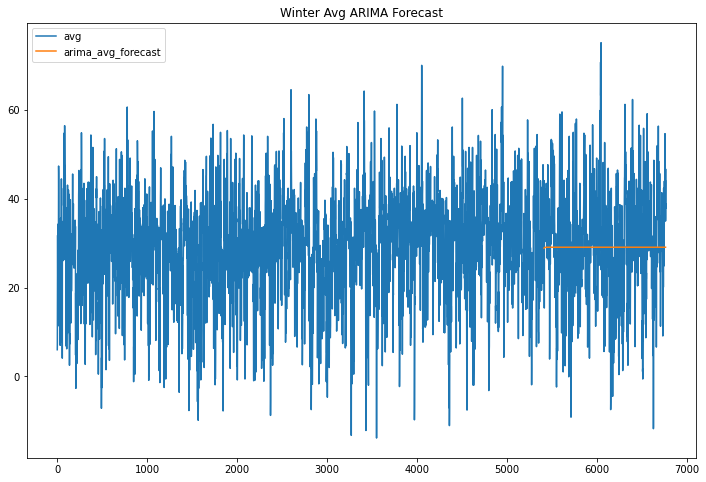

In [76]:
winter_avg_predictions = winter_avg_results_ARIMA.predict(start=5412, end=6763, dynamic=True)
winter_df['arima_avg_forecast'] = winter_avg_predictions
winter_df[['avg','arima_avg_forecast']].plot(figsize=(12,8), title = 'Winter Avg ARIMA Forecast')
acorr_ljungbox(winter_avg_results_ARIMA.resid)

In [77]:
print("Winter Avg Test ARIMA MSE: ", mean_squared_error(winter_df.iloc[5411:]['avg'], winter_avg_predictions))

Winter Avg Test ARIMA MSE:  142.0095646753949


## Winter Avg SARIMA

In [78]:
winter_avg_m3 = pm.auto_arima(train_winter_avg_df, error_action='ignore', seasonal=True, m=3)
winter_avg_m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 5411
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 3)   Log Likelihood              -18405.952
Date:                             Thu, 05 May 2022   AIC                          36821.904
Time:                                     18:49:10   BIC                          36854.884
Sample:                                          0   HQIC                         36833.417
                                            - 5411                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0956      0.012     -7.788      0.000      -0.120      -0.072
ma.L2         -0.3656      0.012    -31.069      0.000      -0.389      -0.343
ar.S.L3        0.4124      0.077      5.387      0.000       0.262       0.562
ma.S.L3       -0.5383      0.070     -7.666      0.000      -0.676      -0.401
sigma2        52.7975      0.774     68.197      0.000      51.280      54.315
===================================================================================
Ljung-Box (L1) (Q):                   2.10   Jarque-Bera (JB):               805.79
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:title={'center':'Winter Avg SARIMA vs. ARIMA'}>

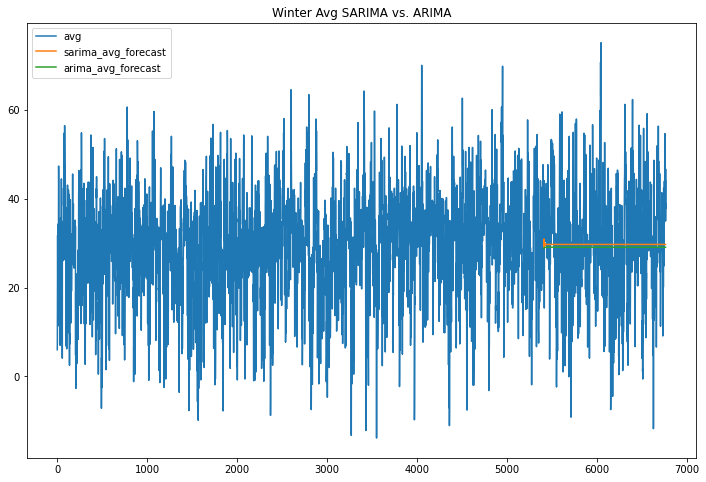

In [79]:
winter_avg_sarima_predict = winter_avg_m3.predict(n_periods = 1352)
winter_avg_sarima_predict_series = pd.Series(winter_avg_sarima_predict, index = range(5412, 6764))
winter_df['sarima_avg_forecast'] = winter_avg_sarima_predict_series
winter_df[['avg','sarima_avg_forecast', 'arima_avg_forecast']].plot(figsize=(12,8), title = 'Winter Avg SARIMA vs. ARIMA')

In [80]:
print("Winter Avg Test SARIMA MSE", mean_squared_error(winter_df.iloc[5411:]['avg'], winter_avg_sarima_predict))

Winter Avg Test SARIMA MSE 141.2226728518465


## Winter Min ARIMA and SARIMA

In [81]:
# 6763 rows
# 80% = 5411 (starting = 2005)
train_winter_min_df = winter_df.iloc[:5411]['min']
ad_test(train_winter_min_df)

1. ADF :  -14.458643953286385
2. P-Value :  6.905921619835056e-27
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression: 5399
5. Critical Values :
	 1% :  -3.431561782148421
	 5% :  -2.8620754853848718
	 10% :  -2.56705503802214


In [82]:
winter_min_stepwise_fit = auto_arima(train_winter_min_df, trace=True, suppress_warnings=True, d=0)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=37649.471, Time=3.68 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=42110.783, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=37782.401, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=39002.183, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=50751.725, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=37670.235, Time=1.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=37706.903, Time=2.14 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=37651.468, Time=4.00 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=37651.518, Time=4.33 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=37727.914, Time=0.74 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=37652.209, Time=1.55 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=37655.939, Time=2.92 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=37652.332, Time=3.58 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.46 sec

Best model:  ARIMA(2,0,2

Text(0.5, 1.0, 'ARIMA on Winter Min Training Data')

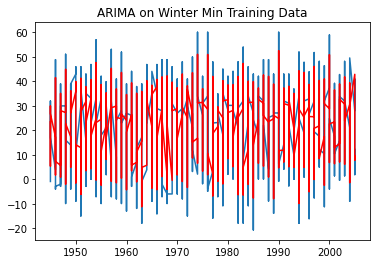

In [83]:
winter_min_model = ARIMA(train_winter_min_df, order=(2,0,2))
winter_min_results_ARIMA = winter_min_model.fit()
plt.plot(winter_df.iloc[:5411]['year'],train_winter_min_df)
plt.plot((winter_df.iloc[:5411]['year']), winter_min_results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA on Winter Min Training Data')

In [84]:
print(winter_min_results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                    min   No. Observations:                 5411
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -18818.735
Date:                Thu, 05 May 2022   AIC                          37649.471
Time:                        18:52:22   BIC                          37689.048
Sample:                             0   HQIC                         37663.287
                               - 5411                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.4889      0.561     41.890      0.000      22.390      24.588
ar.L1          1.2744      0.062     20.539      0.000       1.153       1.396
ar.L2         -0.3399      0.048     -7.026      0.0

In [85]:
print("Winter Min Train MSE: ",mean_squared_error(train_winter_min_df, winter_min_results_ARIMA.fittedvalues))

Winter Min Train MSE:  61.47942651092306


,lb_stat,lb_pvalue
1,0.000500,0.982165
2,0.019659,0.990219
3,0.024717,0.998974
4,1.011831,0.907997
5,1.059323,0.957640
6,2.036639,0.916298
7,2.894140,0.894619
8,2.909330,0.939918
9,4.305138,0.890206
10,4.386482,0.928233


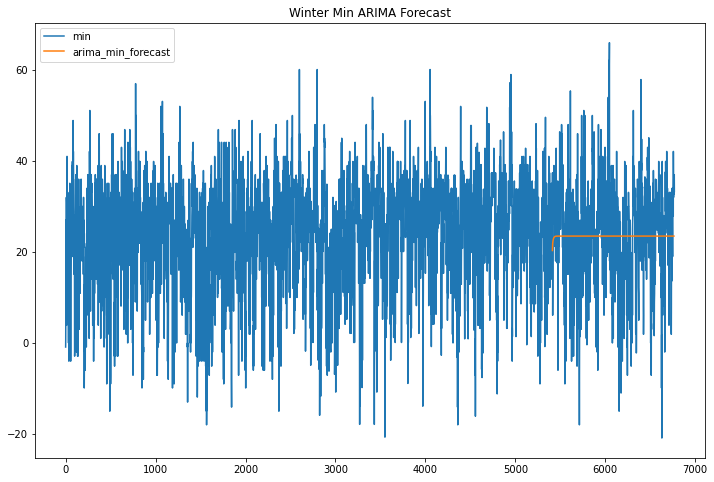

In [86]:
winter_min_predictions = winter_min_results_ARIMA.predict(start=5412, end=6763, dynamic=True)
winter_df['arima_min_forecast'] = winter_min_predictions
winter_df[['min','arima_min_forecast']].plot(figsize=(12,8), title = 'Winter Min ARIMA Forecast')
acorr_ljungbox(winter_min_results_ARIMA.resid)

In [87]:
print("Winter Min Test ARIMA MSE: ", mean_squared_error(winter_df.iloc[5411:]['min'], winter_min_predictions))

Winter Min Test ARIMA MSE:  148.2756105895336


## Winter Min SARIMA

In [88]:
winter_min_m3 = pm.auto_arima(train_winter_min_df, error_action='ignore', seasonal=True, m=3)
winter_min_m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 5411
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 3)   Log Likelihood              -18947.934
Date:                             Thu, 05 May 2022   AIC                          37905.869
Time:                                     18:57:42   BIC                          37938.849
Sample:                                          0   HQIC                         37917.382
                                            - 5411                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1685      0.013    -13.244      0.000      -0.193      -0.144
ma.L2         -0.3396      0.012    -28.246      0.000      -0.363      -0.316
ar.S.L3        0.5189      0.068      7.578      0.000       0.385       0.653
ma.S.L3       -0.6349      0.062    -10.306      0.000      -0.756      -0.514
sigma2        64.5112      1.012     63.769      0.000      62.528      66.494
===================================================================================
Ljung-Box (L1) (Q):                   1.57   Jarque-Bera (JB):               401.45
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:title={'center':'Winter Min SARIMA vs. ARIMA'}>

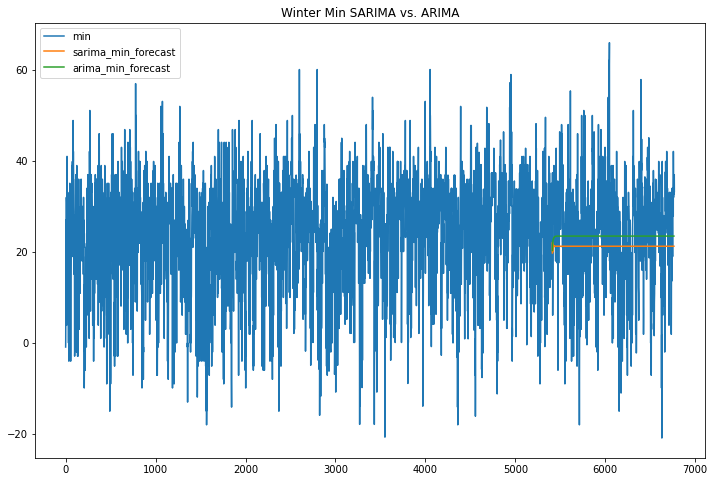

In [89]:
winter_min_sarima_predict = winter_min_m3.predict(n_periods = 1352)
winter_min_sarima_predict_series = pd.Series(winter_min_sarima_predict, index = range(5412, 6764))
winter_df['sarima_min_forecast'] = winter_min_sarima_predict_series
winter_df[['min','sarima_min_forecast', 'arima_min_forecast']].plot(figsize=(12,8), title = 'Winter Min SARIMA vs. ARIMA')

In [90]:
print("Winter Min Test SARIMA MSE", mean_squared_error(winter_df.iloc[5411:]['min'], winter_min_sarima_predict))

Winter Min Test SARIMA MSE 151.0782007042768


## Winter Max ARIMA and SARIMA

In [91]:
# 6763 rows
# 80% = 5411 (starting = 2005)
train_winter_max_df = winter_df.iloc[:5411]['max']
ad_test(train_winter_max_df)

1. ADF :  -15.386830676090312
2. P-Value :  3.350366206013984e-28
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression: 5400
5. Critical Values :
	 1% :  -3.4315615576375107
	 5% :  -2.862075386193924
	 10% :  -2.5670549852194786


In [92]:
winter_max_stepwise_fit = auto_arima(train_winter_max_df, trace=True, suppress_warnings=True, d=0)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=37447.320, Time=3.66 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=41688.188, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=37596.905, Time=0.34 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=38643.632, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=54589.679, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=37462.830, Time=2.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=37503.239, Time=2.03 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=37449.317, Time=4.67 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=37449.964, Time=4.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=37531.337, Time=0.84 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=37450.012, Time=1.87 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=37458.558, Time=2.95 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=37451.549, Time=4.61 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.77 sec

Best model:  ARIMA(2,0,2

Text(0.5, 1.0, 'ARIMA on Winter Max Training Data')

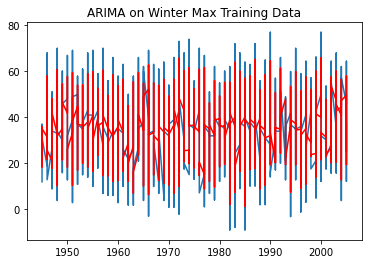

In [93]:
winter_max_model = ARIMA(train_winter_max_df, order=(2,0,2))
winter_max_results_ARIMA = winter_max_model.fit()
plt.plot(winter_df.iloc[:5411]['year'],train_winter_max_df)
plt.plot((winter_df.iloc[:5411]['year']), winter_max_results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA on Winter Max Training Data')

In [94]:
print(winter_max_results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                    max   No. Observations:                 5411
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -18717.660
Date:                Thu, 05 May 2022   AIC                          37447.320
Time:                        19:01:20   BIC                          37486.897
Sample:                             0   HQIC                         37461.136
                               - 5411                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.7510      0.484     73.799      0.000      34.802      36.701
ar.L1          1.2048      0.065     18.441      0.000       1.077       1.333
ar.L2         -0.2849      0.049     -5.759      0.0

In [95]:
print("Winter Max Train MSE: ",mean_squared_error(train_winter_max_df, winter_max_results_ARIMA.fittedvalues))

Winter Max Train MSE:  59.22259460141009


,lb_stat,lb_pvalue
1,0.001403,0.970124
2,0.009360,0.995331
3,0.184502,0.980052
4,0.347374,0.986554
5,1.193853,0.945466
6,1.217015,0.976036
7,1.575523,0.979579
8,3.503798,0.898895
9,4.291981,0.891166
10,5.296071,0.870543


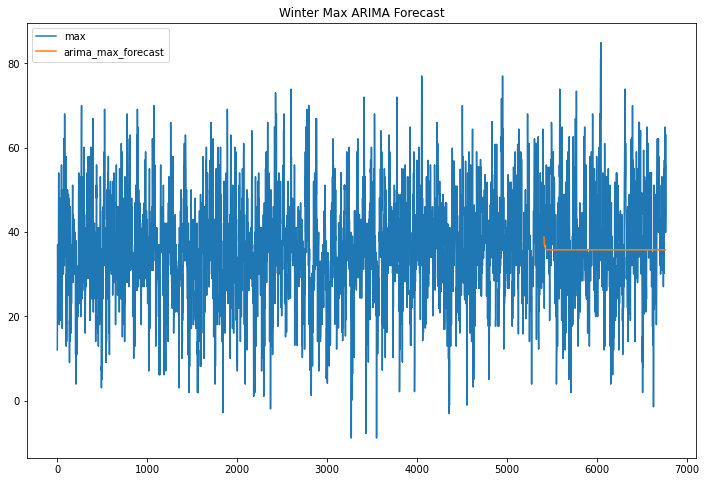

In [96]:
winter_max_predictions = winter_max_results_ARIMA.predict(start=5412, end=6763, dynamic=True)
winter_df['arima_max_forecast'] = winter_max_predictions
winter_df[['max','arima_max_forecast']].plot(figsize=(12,8), title = 'Winter Max ARIMA Forecast')
acorr_ljungbox(winter_max_results_ARIMA.resid)

In [97]:
print("Winter Max Test ARIMA MSE: ", mean_squared_error(winter_df.iloc[5411:]['max'], winter_max_predictions))

Winter Max Test ARIMA MSE:  163.1486571227545


## Winter Max SARIMA

In [98]:
winter_max_m3 = pm.auto_arima(train_winter_max_df, error_action='ignore', seasonal=True, m=3)
winter_max_m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5411
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -18717.660
Date:                Thu, 05 May 2022   AIC                          37447.320
Time:                        19:03:37   BIC                          37486.897
Sample:                             0   HQIC                         37461.136
                               - 5411                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8612      0.635      4.506      0.000       1.617       4.106
ar.L1          1.2049      0.065     18.440      0.000       1.077       1.333
ar.L2         -0.2849      0.049     -5.760      0.000      -0.382      -0.188
ma.L1         -0.4023      0.065     -6.226      0.000      -0.529      -0.276
ma.L2         -0.2337      0.017    -14.087      0.000      -0.266      -0.201
sigma2        59.1670      0.834     70.968      0.000      57.533      60.801
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               851.28
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.24
Prob(H) (two-sided):                  0.66   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:title={'center':'Winter Max SARIMA vs. ARIMA'}>

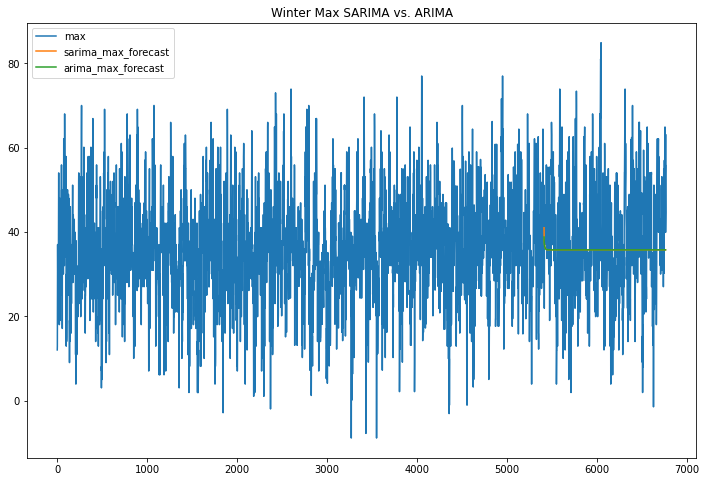

In [99]:
winter_max_sarima_predict = winter_max_m3.predict(n_periods = 1352)
winter_max_sarima_predict_series = pd.Series(winter_max_sarima_predict, index = range(5412, 6764))
winter_df['sarima_max_forecast'] = winter_max_sarima_predict_series
winter_df[['max','sarima_max_forecast', 'arima_max_forecast']].plot(figsize=(12,8), title = 'Winter Max SARIMA vs. ARIMA')

In [100]:
print("Winter Max Test SARIMA MSE", mean_squared_error(winter_df.iloc[5411:]['max'], winter_max_sarima_predict))

Winter Max Test SARIMA MSE 163.13710684159346


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -156.679
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10629.4    0.00327104       298.612           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10635.2    0.00546017       399.486           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         10638   0.000203618       93.8937           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       10638.1   5.10599e-05       74.8728   6.752e-07       0.001      451  LS failed, Hessian reset 
     370       10638.1   7.44144e-07       74.7143           1           1      480   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -219.607
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8696.01    0.00364032       79.2167           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8701.24   0.000554931       90.6846       1.938      0.1938      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       8701.38    0.00040034       135.154   6.931e-06       0.001      278  LS failed, Hessian reset 
     258       8701.68   0.000618506       71.7545   7.743e-06       0.001      365  LS failed, Hessian reset 
     299       8701.75   0.000246323       71.2766           1           1      415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       8701.76   6.01403e-05       79.4574   9.041e-07       0.001      491  LS failed, Hessian rese

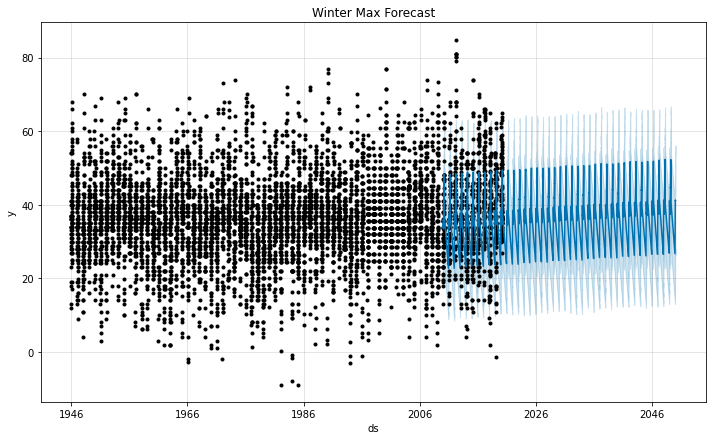

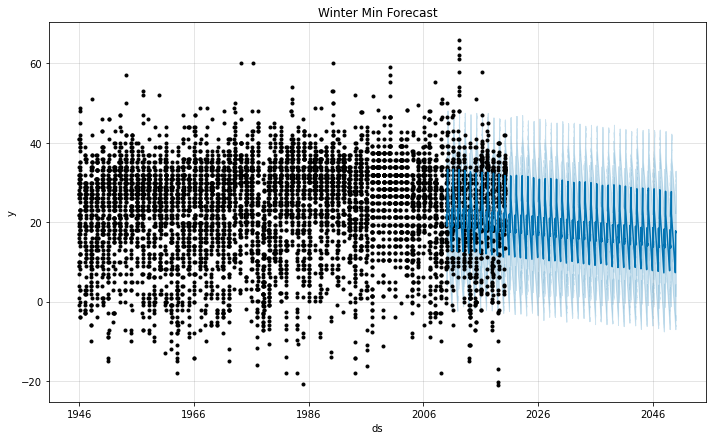

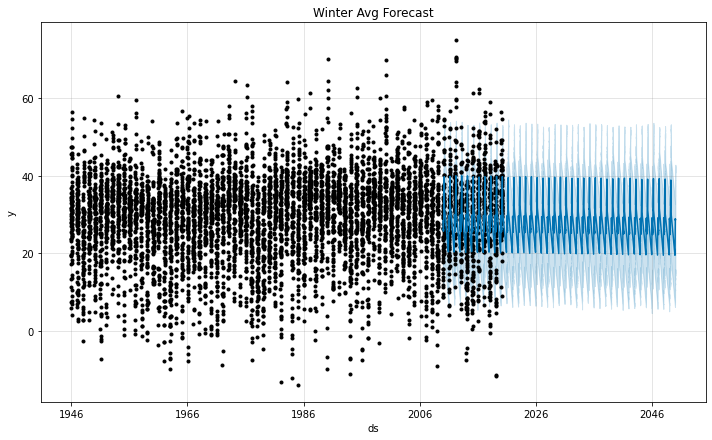

<Figure size 1440x720 with 0 Axes>

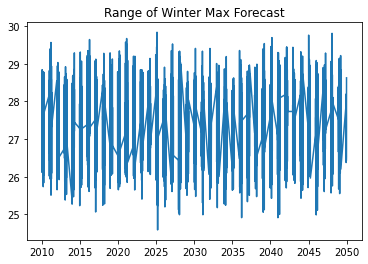

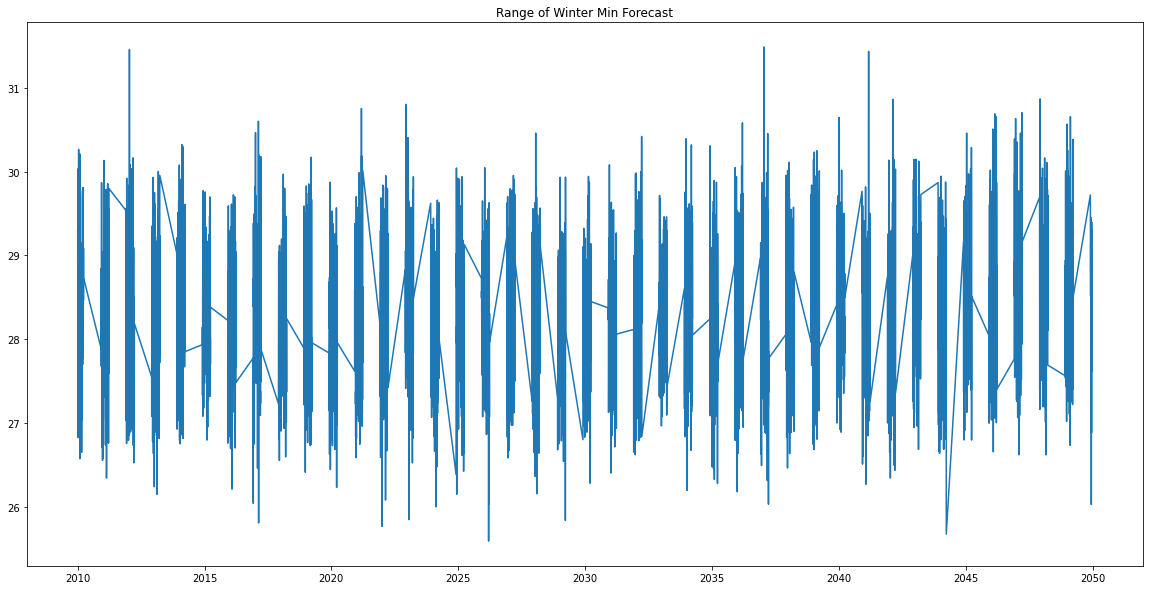

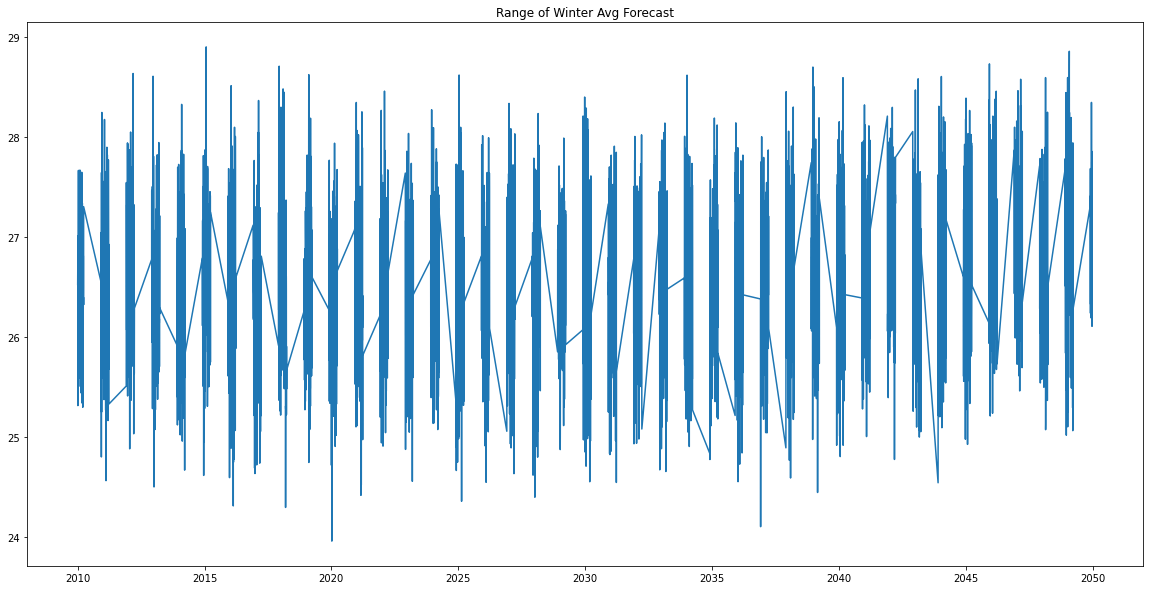

<Figure size 1440x720 with 0 Axes>

In [101]:
# winter forecasts using FBProphet

# define the model
winter_max_model = Prophet()
winter_min_model = Prophet()
winter_avg_model = Prophet()

# fit the model
max_df = winter_df[['date', 'max']]
max_df.set_index('date', inplace = True)
max_df['ds'] = max_df.index
max_df.columns = ['y', 'ds']
winter_max_model.fit(max_df);

min_df = winter_df[['date', 'min']]
min_df.set_index('date', inplace = True)
min_df['ds'] = min_df.index
min_df.columns = ['y', 'ds']
winter_min_model.fit(min_df);

avg_df = winter_df[['date', 'avg']]
avg_df.set_index('date', inplace = True)
avg_df['ds'] = avg_df.index
avg_df.columns = ['y', 'ds']
winter_avg_model.fit(avg_df);

# define the period for which we want a prediction -- winter months 2010-2050
def prediction_dates(months):
    future = list()
    for j in range(2010, 2050):
        for i in months:
            mon = str(i)
            if len(mon) == 1:
                mon = "0{num}".format(num = i)
            for d in range(1, 29):
                day = str(d)
                if len(day) == 1:
                    day = "0{num}".format(num = d)
                date = "{year}-{month}-{dayS}".format(year = j, month = mon, dayS = day)
                future.append([date])
    return future

winter_months = [12, 1, 2, 3]
max_future = prediction_dates(winter_months);
min_future = prediction_dates(winter_months);
avg_future = prediction_dates(winter_months);

max_future = pd.DataFrame(max_future);
min_future = pd.DataFrame(min_future);
avg_future = pd.DataFrame(avg_future);

max_future.columns = ['ds']
min_future.columns = ['ds']
avg_future.columns = ['ds']

max_future['ds']= pd.to_datetime(max_future['ds'], format='%Y-%m-%d')
min_future['ds']= pd.to_datetime(min_future['ds'], format='%Y-%m-%d')
avg_future['ds']= pd.to_datetime(avg_future['ds'], format='%Y-%m-%d')

# use the model to make a forecast
max_forecast = winter_max_model.predict(max_future);
min_forecast = winter_min_model.predict(min_future);
avg_forecast = winter_avg_model.predict(avg_future);

# plot forecast

winter_max_model.plot(max_forecast)
plt.title("Winter Max Forecast")
winter_min_model.plot(min_forecast)
plt.title("Winter Min Forecast")
winter_avg_model.plot(avg_forecast)
plt.title("Winter Avg Forecast")
plt.show()

# plot difference between yhat_upper and yhat_lower
plt.plot(max_forecast['ds'], max_forecast['yhat_upper'] - max_forecast['yhat_lower'])
plt.title("Range of Winter Max Forecast")
plt.figure(figsize=(20,10))

plt.plot(min_forecast['ds'], min_forecast['yhat_upper'] - min_forecast['yhat_lower'])
plt.title("Range of Winter Min Forecast")
plt.figure(figsize=(20,10))

plt.plot(avg_forecast['ds'], avg_forecast['yhat_upper'] - avg_forecast['yhat_lower'])
plt.title("Range of Winter Avg Forecast")
plt.figure(figsize=(20,10))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -49.6802
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       15570.8    0.00117215        617.61      0.4733      0.4733      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       15576.5   0.000345034       141.856           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       15577.9   0.000171927       63.5149      0.2294           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333       15578.2   0.000265162       379.811   1.577e-06       0.001      430  LS failed, Hessian reset 
     399       15578.6   0.000206375       64.2461      0.6701      0.6701      504   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     409       15578.7   0.000121958    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -115.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       15616.9     0.0106567       1714.12           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       15623.7    0.00288283       311.484           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         15626     0.0011372       613.961      0.7662      0.7662      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     382       15627.2   5.66405e-05       184.339   2.388e-07       0.001      487  LS failed, Hessian reset 
     399       15627.4     0.0012411       169.602           1           1      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       15627.9   0.000156373    

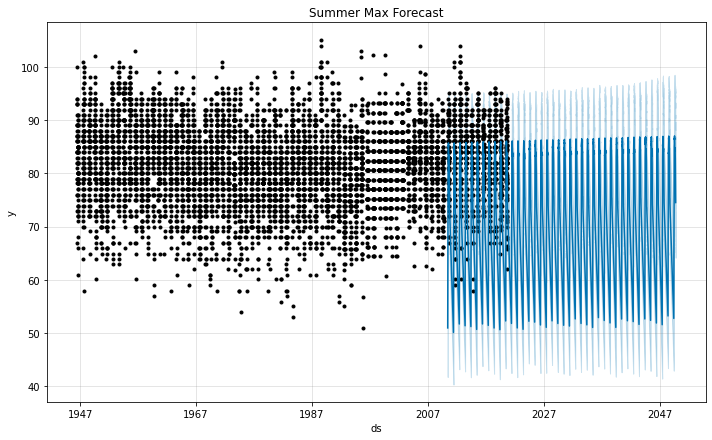

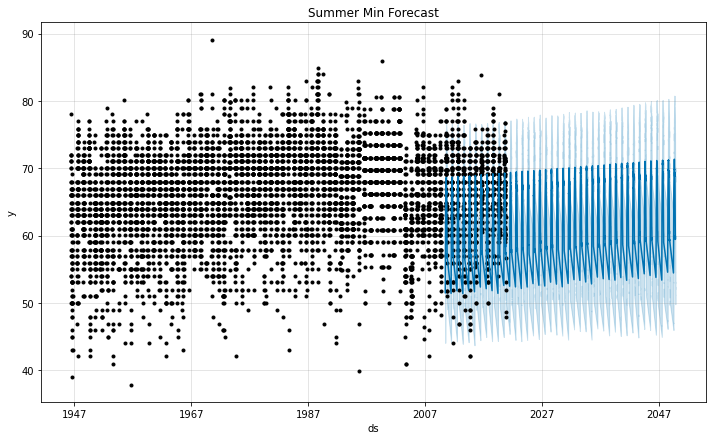

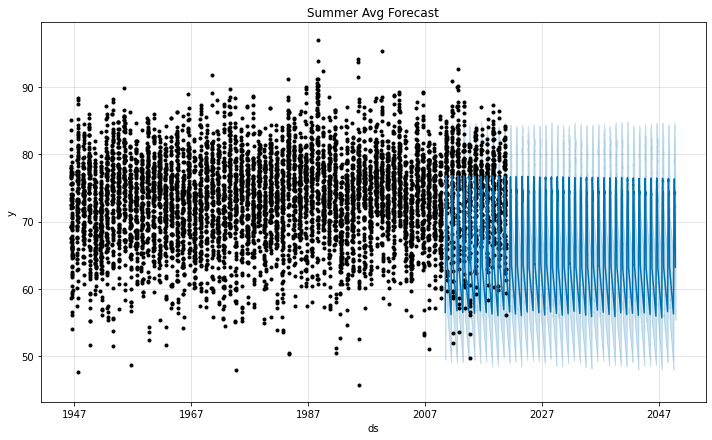

<Figure size 1440x720 with 0 Axes>

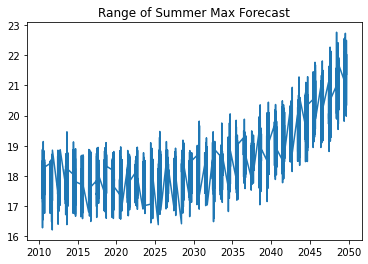

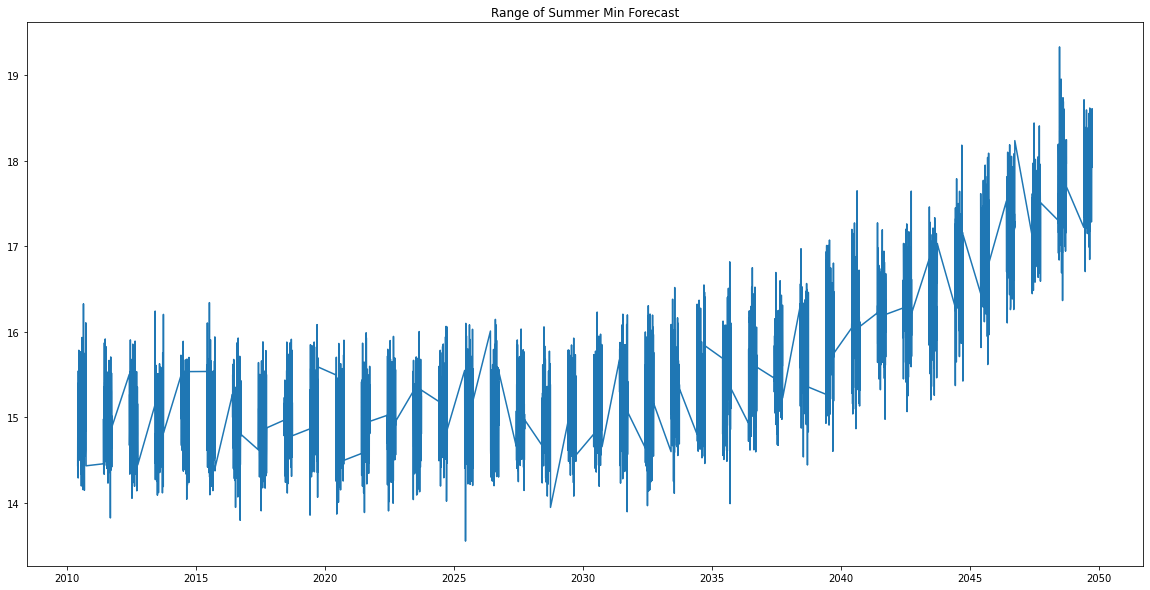

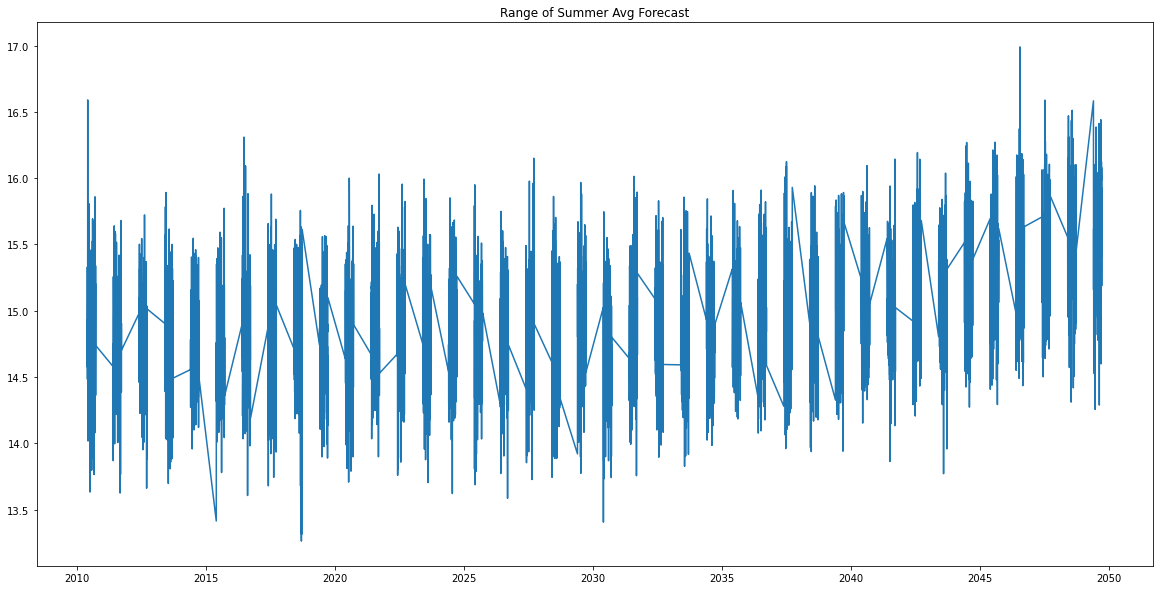

<Figure size 1440x720 with 0 Axes>

In [102]:
# summer forecasts

# define the model
summer_max_model = Prophet()
summer_min_model = Prophet()
summer_avg_model = Prophet()

# fit the model
summer_max_df = summer_df[['date', 'max']]
summer_max_df.set_index('date', inplace = True)
summer_max_df['ds'] = summer_max_df.index
summer_max_df.columns = ['y', 'ds']
summer_max_model.fit(summer_max_df)

summer_min_df = summer_df[['date', 'min']]
summer_min_df.set_index('date', inplace = True)
summer_min_df['ds'] = summer_min_df.index
summer_min_df.columns = ['y', 'ds']
summer_min_model.fit(summer_min_df)

summer_avg_df = summer_df[['date', 'avg']]
summer_avg_df.set_index('date', inplace = True)
summer_avg_df['ds'] = summer_avg_df.index
summer_avg_df.columns = ['y', 'ds']
summer_avg_model.fit(summer_avg_df)

summer_months = [6, 7, 8, 9]
summer_max_future = prediction_dates(summer_months)
summer_min_future = prediction_dates(summer_months)
summer_avg_future = prediction_dates(summer_months)

summer_max_future = pd.DataFrame(summer_max_future)
summer_min_future = pd.DataFrame(summer_min_future)
summer_avg_future = pd.DataFrame(summer_avg_future)

summer_max_future.columns = ['ds']
summer_min_future.columns = ['ds']
summer_avg_future.columns = ['ds']

summer_max_future['ds']= pd.to_datetime(summer_max_future['ds'], format='%Y-%m-%d')
summer_min_future['ds']= pd.to_datetime(summer_min_future['ds'], format='%Y-%m-%d')
summer_avg_future['ds']= pd.to_datetime(summer_avg_future['ds'], format='%Y-%m-%d')

# use the model to make a forecast
summer_max_forecast = summer_max_model.predict(summer_max_future)
summer_min_forecast = summer_min_model.predict(summer_min_future)
summer_avg_forecast = summer_avg_model.predict(summer_avg_future)

# plot forecast
summer_max_model.plot(summer_max_forecast)
plt.title("Summer Max Forecast")
summer_min_model.plot(summer_min_forecast)
plt.title("Summer Min Forecast")
summer_avg_model.plot(summer_avg_forecast)
plt.title("Summer Avg Forecast")
plt.show()

# plot difference between yhat_upper and yhat_lower
plt.plot(summer_max_forecast['ds'], summer_max_forecast['yhat_upper'] - summer_max_forecast['yhat_lower'])
plt.title("Range of Summer Max Forecast")
plt.figure(figsize=(20,10))

plt.plot(summer_min_forecast['ds'], summer_min_forecast['yhat_upper'] - summer_min_forecast['yhat_lower'])
plt.title("Range of Summer Min Forecast")
plt.figure(figsize=(20,10))

plt.plot(summer_avg_forecast['ds'], summer_avg_forecast['yhat_upper'] - summer_avg_forecast['yhat_lower'])
plt.title("Range of Summer Avg Forecast")
plt.figure(figsize=(20,10))